In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import joblib
import requests

In [10]:
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
zip_path = 'bank+marketing.zip'
response = requests.get(url, verify=False)  

with open(zip_path, 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('bank+marketing')

csv_path = os.path.join('bank+marketing', 'bank', 'bank-full.csv')
print(f"Файл сохранен по пути: {csv_path}")
data = pd.read_csv(csv_path, sep=';')
print(data.head())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Файл сохранен по пути: bank+marketing/bank/bank-full.csv
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [12]:
columns = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
    'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]
data = data[columns]
data['y'] = (data['y'] == 'yes').astype(int)

# Split data
df_train, df_temp = train_test_split(data, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

In [13]:
numerical_features = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

for feature in numerical_features:
    auc = roc_auc_score(df_train['y'], df_train[feature])
    if auc < 0.5:
        df_train[feature] = -df_train[feature]
        auc = roc_auc_score(df_train['y'], df_train[feature])
    auc_scores[feature] = auc

print("AUC scores for features:", auc_scores)

AUC scores for features: {'balance': np.float64(0.5916931412945473), 'day': np.float64(0.5291275984648961), 'duration': np.float64(0.8128648066681694), 'previous': np.float64(0.5986704105715122)}


In [ ]:
#Какая числовая переменная (из следующих 4) имеет наивысший AUC? Ответ: duration

In [14]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train['y']

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val['y']

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_preds = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print("Validation AUC:", round(val_auc, 3))

Validation AUC: 1.0


In [ ]:
#Какой AUC у этой модели на валидационном наборе данных? (округлите до 3 знаков) Ответ: 1

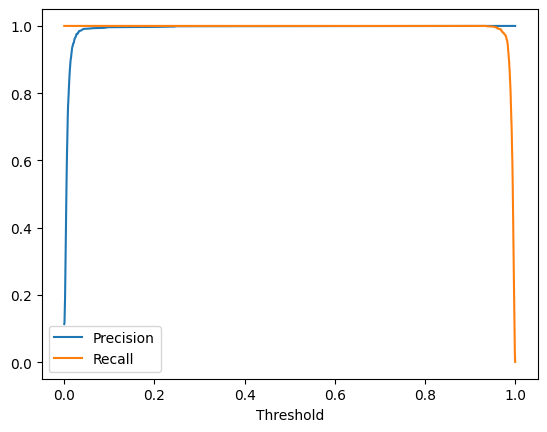

Threshold where precision meets recall: 0.935


In [15]:
precisions, recalls, thresholds = precision_recall_curve(y_val, val_preds)
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.show()

intersection_threshold = thresholds[np.argmin(abs(precisions - recalls))]
print("Threshold where precision meets recall:", round(intersection_threshold, 3))

In [19]:
from sklearn.metrics import f1_score
f1_scores = [f1_score(y_val, val_preds >= t) for t in thresholds]
best_f1_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1 score:", round(best_f1_threshold, 3))

Best threshold for F1 score: 0.935


In [25]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []

for train_idx, val_idx in kf.split(df_train):
    train_data, val_data = df_train.iloc[train_idx], df_train.iloc[val_idx]
    train_dict = train_data.drop(columns=['y']).to_dict(orient='records')
    val_dict = val_data.drop(columns=['y']).to_dict(orient='records')
    
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)
    y_train = train_data['y'].values
    y_val = val_data['y'].values
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

# Стандартная ошибка
std_error = np.std(aucs)
print(f'standart mistake: {std_error}')

standart mistake: 0.004116563175424417


In [26]:
C_values = [0.000001, 0.001, 1]
mean_scores = []
std_scores = []

for C in C_values:
    aucs = []
    for train_idx, val_idx in kf.split(df_train):
        train_data, val_data = df_train.iloc[train_idx], df_train.iloc[val_idx]
        train_dict = train_data.drop(columns=['y']).to_dict(orient='records')
        val_dict = val_data.drop(columns=['y']).to_dict(orient='records')
        
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)
        y_train = train_data['y'].values
        y_val = val_data['y'].values
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    
    mean_scores.append(np.mean(aucs))
    std_scores.append(np.std(aucs))

# Определение лучшего значения C
best_index = np.argmax(mean_scores)
best_C = C_values[best_index]
print(f'best C: {best_C}, {round(mean_scores[best_index], 3)}, {round(std_scores[best_index], 3)}')

best C: 1, 0.908, 0.004
